In [84]:
# !pip install evaluate

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import sys

sys.path.append("../")

In [4]:
from pathlib import Path

MODELS_DIR = Path("../data/models")
MODELS_DIR.resolve()

PosixPath('/home/djaniak/projects/information-bottleneck/data/models')

In [5]:
import os
import torch

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = ""

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
device

device(type='cpu')

In [17]:
import json
import os
from pathlib import Path


data_dir = Path("../data/entropies/gptq-wikitext2")
entropies = []

for entropies_file in data_dir.rglob("*.json"):
    with open(entropies_file, "r") as f:
        p = json.load(f)
    entropies.append(p)

In [18]:
import pandas as pd

df = pd.DataFrame(entropies)
df["model_name"] = df["model"].apply(lambda x: x.split("/")[-1])

df.head()

,model,quantization,bits,dataset,ppl,entropy,logD_normalized_entropy,logN_normalized_entropy,logNlogD_normalized_entropy,model_name
0,facebook/opt-13b,gptq,16,wikitext2,10.128001,5.689793,0.746240,1.151397,0.151010,opt-13b
1,facebook/opt-2.7b,gptq,2,wikitext2,109.257553,5.151593,0.675653,1.042486,0.136726,opt-2.7b
2,facebook/opt-13b,gptq,2,wikitext2,19.503454,5.920738,0.776529,1.198132,0.157140,opt-13b
3,facebook/opt-6.7b,gptq,8,wikitext2,10.865003,5.550685,0.727995,1.123247,0.147318,opt-6.7b
4,facebook/opt-6.7b,gptq,4,wikitext2,11.090740,5.589587,0.733097,1.131119,0.148351,opt-6.7b


In [19]:
def get_directory_size(directory):
    total_size = 0
    for dirpath, dirnames, filenames in os.walk(directory):
        for filename in filenames:
            filepath = os.path.join(dirpath, filename)
            # Skip if it is symbolic link
            if not os.path.islink(filepath):
                total_size += os.path.getsize(filepath)
    return total_size


def read_model_dir_size(model: str, bits: int):
    if bits < 16:
        model_dir = MODELS_DIR / "quantized" /(model.replace("/", "_") + f"-gptq-{bits}bit-128g-wikitext2")
    else:
        model_dir = MODELS_DIR / "original" / model.replace("/", "_")
    assert model_dir.exists()
    return get_directory_size(model_dir)

df["size"] = df.apply(lambda x: read_model_dir_size(x["model"], x["bits"]), axis=1)
df["size [MB]"] = df["size"].apply(lambda x: x / (1024**2))
df["size [GB]"] = df["size"].apply(lambda x: x / (1024**3))

In [20]:
df.sort_values(by=["model", "bits"]).head(5)

,model,quantization,bits,dataset,ppl,entropy,logD_normalized_entropy,logN_normalized_entropy,logNlogD_normalized_entropy,model_name,size,size [MB],size [GB]
14,facebook/opt-1.3b,gptq,2,wikitext2,231.692322,5.310492,0.696493,1.074641,0.140944,opt-1.3b,746600224,712.013458,0.695326
11,facebook/opt-1.3b,gptq,3,wikitext2,17.406363,5.387903,0.706646,1.090306,0.142998,opt-1.3b,898774920,857.138557,0.837049
18,facebook/opt-1.3b,gptq,4,wikitext2,16.128828,5.344523,0.700956,1.081528,0.141847,opt-1.3b,1050950376,1002.264381,0.978774
16,facebook/opt-1.3b,gptq,8,wikitext2,15.763891,5.313105,0.696836,1.075170,0.141013,opt-1.3b,1659648992,1582.764618,1.545669
19,facebook/opt-1.3b,gptq,16,wikitext2,14.624232,5.346810,0.701256,1.081990,0.141907,opt-1.3b,2631562561,2509.653626,2.450834


In [26]:
df.sort_values(by=["model", "bits"]).tail(5)

,model,quantization,bits,dataset,ppl,entropy,logD_normalized_entropy,logN_normalized_entropy,logNlogD_normalized_entropy,model_name,size,size [MB],size [GB]
17,facebook/opt-6.7b,gptq,2,wikitext2,24.644361,5.650591,0.741098,1.143464,0.149970,opt-6.7b,2572581353,2453.404763,2.395903
10,facebook/opt-6.7b,gptq,3,wikitext2,11.536489,5.605560,0.735192,1.134352,0.148775,opt-6.7b,3384179433,3227.405007,3.151763
4,facebook/opt-6.7b,gptq,4,wikitext2,11.090740,5.589587,0.733097,1.131119,0.148351,opt-6.7b,4195777377,4001.405122,3.907622
3,facebook/opt-6.7b,gptq,8,wikitext2,10.865003,5.550685,0.727995,1.123247,0.147318,opt-6.7b,7442169193,7097.405618,6.931060
13,facebook/opt-6.7b,gptq,16,wikitext2,10.860077,5.550795,0.728009,1.123269,0.147321,opt-6.7b,13317054771,12700.133105,12.402474


# Perplexity

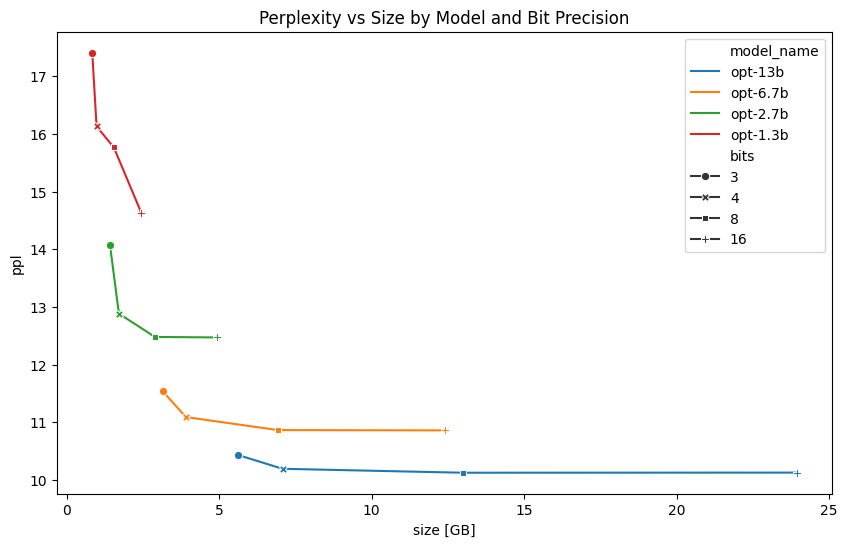

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))  # Adjust the figure size as desired

ax1 = sns.lineplot(
    data=df[df['bits'] > 2],
    x="size [GB]",
    y="ppl",
    hue="model_name",
    markers=True,
    dashes=False,
    legend=False
)
ax2 = sns.lineplot(
    data=df[df['bits'] > 2],
    x="size [GB]",
    y="ppl",
    hue="model_name",
    style="bits",
    markers=True,
    dashes=False,
)

plt.xlabel('size [GB]')
plt.ylabel('ppl')
plt.title('Perplexity vs Size by Model and Bit Precision')
plt.show()


# Entropy

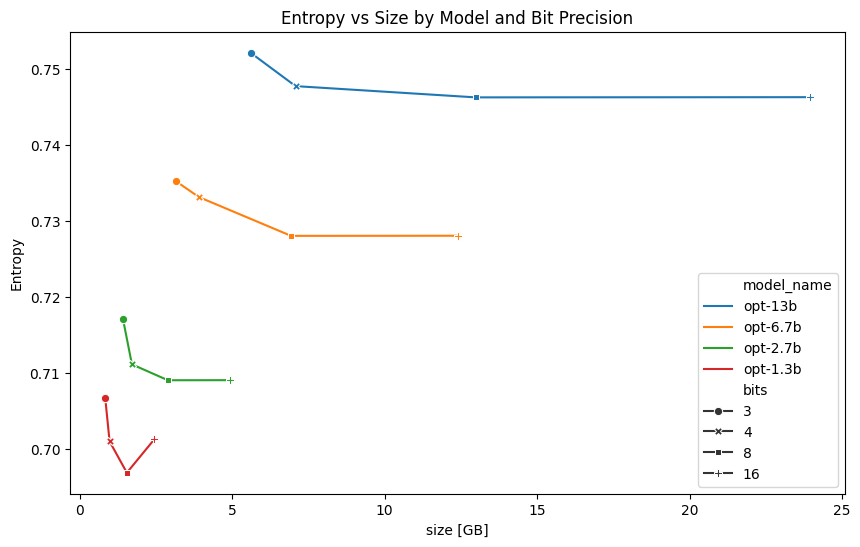

In [27]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))  # Adjust the figure size as desired

ax1 = sns.lineplot(
    data=df[df['bits'] > 2],
    x="size [GB]",
    y="logD_normalized_entropy",
    hue="model_name",
    markers=True,
    dashes=False,
    legend=False
)
ax2 = sns.lineplot(
    data=df[df['bits'] > 2],
    x="size [GB]",
    y="logD_normalized_entropy",
    hue="model_name",
    style="bits",
    markers=True,
    dashes=False,
)

plt.xlabel('size [GB]')
plt.ylabel('Entropy')
plt.title('Entropy vs Size by Model and Bit Precision')
plt.show()
